<a href="https://colab.research.google.com/github/luigiselmi/dl_tensorflow/blob/main/epfl_building_footprints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rooftop detection
We use the data from [Cadei et al - Detecting available rooftop area from satellite images to install photovoltaic panels](https://github.com/riccardocadei/photovoltaic-detection/tree/main) to implement a semantic segmentation model for the extraction of building footprints from satellite images.

In [1]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
from skimage import io
from skimage import exposure
from skimage.io import imsave, imread
import warnings
warnings.filterwarnings('ignore')


Train, validation, and test data are provided in separate folders.

In [2]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [3]:
p_train = Path('/content/drive/MyDrive/EPFL_Building_Footprints/data/residencial/train/')
train_paths = []
[train_paths.append(sub_folder) for sub_folder in p_train.iterdir() if sub_folder.is_dir()]
train_labels_path = train_paths[1]
train_images_path = train_paths[0]
print(train_images_path)
print(train_labels_path)

/content/drive/MyDrive/EPFL_Building_Footprints/data/residencial/train/images
/content/drive/MyDrive/EPFL_Building_Footprints/data/residencial/train/labels


In [4]:
p_val = Path('/content/drive/MyDrive/EPFL_Building_Footprints/data/residencial/val/')
val_paths = []
[val_paths.append(sub_folder) for sub_folder in p_val.iterdir() if sub_folder.is_dir()]
val_labels_path = val_paths[1]
val_images_path = val_paths[0]
print(val_images_path)
print(val_labels_path)

/content/drive/MyDrive/EPFL_Building_Footprints/data/residencial/val/images
/content/drive/MyDrive/EPFL_Building_Footprints/data/residencial/val/labels


In [5]:
p_test = Path('/content/drive/MyDrive/EPFL_Building_Footprints/data/residencial/test/')
test_paths = []
[test_paths.append(sub_folder) for sub_folder in p_test.iterdir() if sub_folder.is_dir()]
test_labels_path = test_paths[0]
test_images_path = test_paths[1]
print(test_images_path)
print(test_labels_path)

/content/drive/MyDrive/EPFL_Building_Footprints/data/residencial/test/images
/content/drive/MyDrive/EPFL_Building_Footprints/data/residencial/test/labels


In [6]:
def create_list(raster_path):
    """
    This function extracts the raster file paths (png images or masks) in the
    folder path and puts them in a list. The list is sorted in order to have
    each image and mask with the same index
    """
    img_list = []
    for file in os.listdir(raster_path):
        if file.endswith(".png"):
            img_list.append(os.path.join(raster_path, file))

    return sorted(img_list)

In [7]:
train_images_list = create_list(train_images_path)
len(train_images_list)

244

In [8]:
val_images_list = create_list(val_images_path)
len(val_images_list)

30

In [9]:
test_images_list = create_list(test_images_path)
len(test_images_list)

31

In [10]:
print(train_images_list[0])

/content/drive/MyDrive/EPFL_Building_Footprints/data/residencial/train/images/DOP25_LV03_1301_11_2015_1_15_497500.0_119187.5.png


In [11]:
img_0 = io.imread(train_images_list[0])
img_0.shape

(250, 250, 3)

In [12]:
def plot_raster(ax, list_images):
  index = 0
  for col in range(0, fig_cols):
    for row in range(0, fig_rows):
      img_natcol = io.imread(list_images[index])
      img_equalized = exposure.equalize_hist(img_natcol)
      ax[row, col].set_axis_off()
      ax[row, col].imshow(img_equalized)
      index += 1

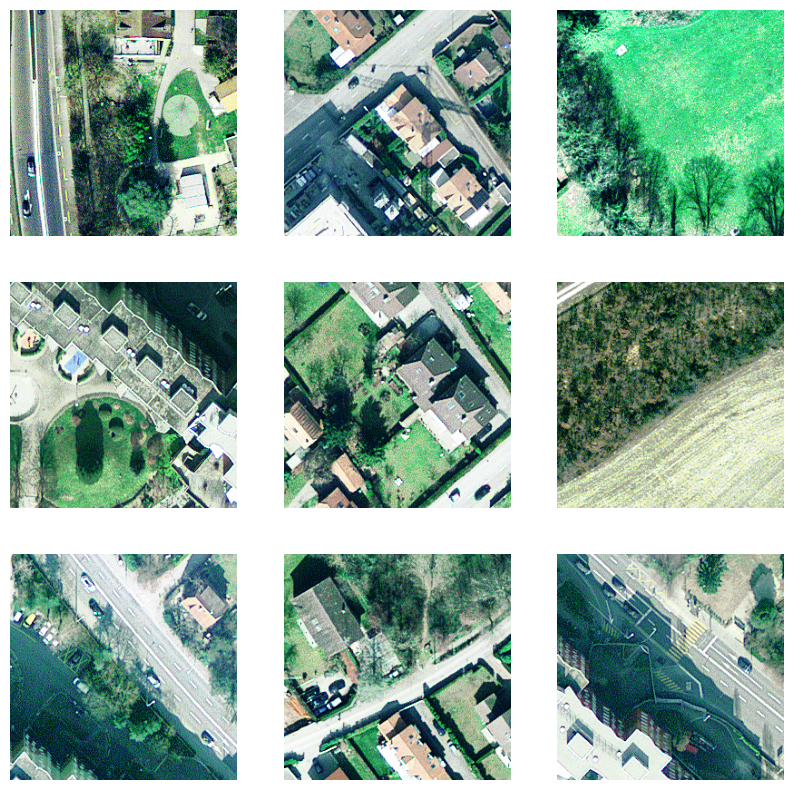

In [13]:
fig_rows = 3
fig_cols = 3
fig, ax = plt.subplots(nrows=fig_rows, ncols=fig_cols, figsize=(10, 10))
plot_raster(ax, train_images_list)


In [14]:
train_labels_list = create_list(train_labels_path)
len(train_labels_list)

244

In [15]:
val_labels_list = create_list(val_labels_path)
len(val_labels_list)

30

In [16]:
test_labels_list = create_list(test_labels_path)
len(test_labels_list)

31

In [17]:
print(train_labels_list[0])

/content/drive/MyDrive/EPFL_Building_Footprints/data/residencial/train/labels/DOP25_LV03_1301_11_2015_1_15_497500.0_119187.5_label.png


In [18]:
label_0 = io.imread(train_labels_list[0])
label_0.shape

(250, 250, 3)

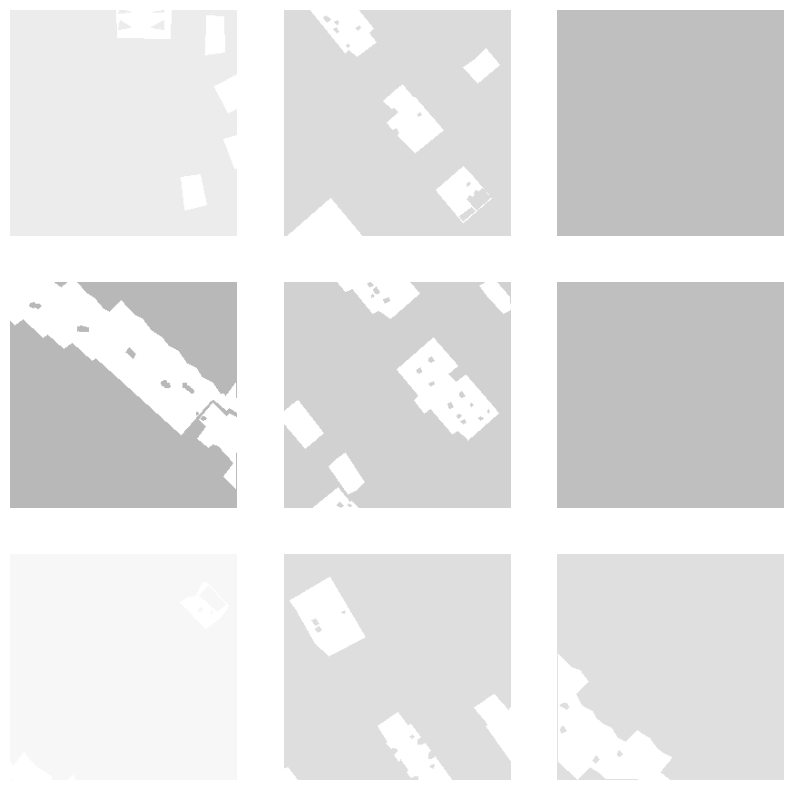

In [19]:
fig, ax = plt.subplots(nrows=fig_rows, ncols=fig_cols, figsize=(10, 10))
plot_raster(ax, train_labels_list)

## Fully Convolutional Network
We use a simple FCN model with an encoder and decoder part to segment the images.

In [20]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import load_img, img_to_array

In [21]:
import random
img_size = (224, 224)
num_train_imgs = len(train_images_list)
random.Random(1337).shuffle(train_images_list)
random.Random(1337).shuffle(train_labels_list)

In [22]:
def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

In [23]:
def path_to_target(path):
    img = img_to_array(load_img(path, target_size=img_size, color_mode="grayscale"))
    img = img.astype("uint8") - 255
    return img

In [24]:
train_input_imgs = np.zeros((num_train_imgs,) + img_size + (3,), dtype="float32")
train_targets = np.zeros((num_train_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_train_imgs):
    train_input_imgs[i] = path_to_input_image(train_images_list[i])
    train_targets[i] = path_to_target(train_labels_list[i])

In [25]:
train_input_imgs[0].min(), train_input_imgs[0].max()

(0.0, 255.0)

In [26]:
train_input_imgs[0].shape

(224, 224, 3)

In [27]:
train_targets[0].min(), train_targets[0].max()

(0, 1)

In [28]:
train_targets[0].shape

(224, 224, 1)

In [29]:
num_val_imgs = len(val_images_list)
val_input_imgs = np.zeros((num_val_imgs,) + img_size + (3,), dtype="float32")
val_targets = np.zeros((num_val_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_val_imgs):
    val_input_imgs[i] = path_to_input_image(val_images_list[i])
    val_targets[i] = path_to_target(val_labels_list[i])

In [88]:
num_test_imgs = len(test_images_list)
test_input_imgs = np.zeros((num_test_imgs,) + img_size + (3,), dtype="float32")
test_targets = np.zeros((num_test_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_test_imgs):
    test_input_imgs[i] = path_to_input_image(test_images_list[i])
    test_targets[i] = path_to_target(test_labels_list[i])

## Data augmentation

In [30]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
])

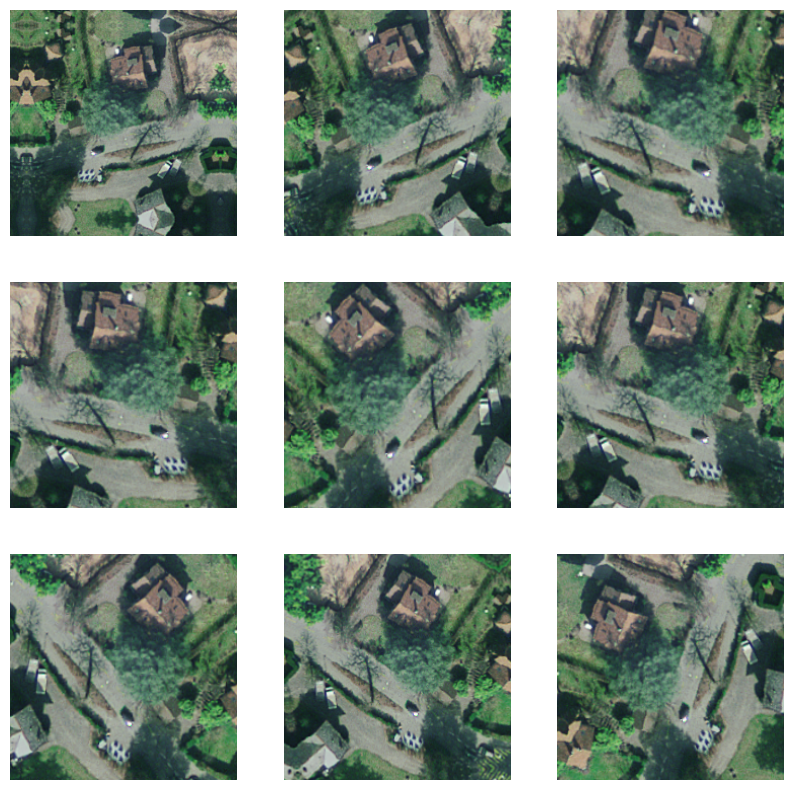

In [31]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_images = data_augmentation(train_input_imgs)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_images[0].numpy().astype("uint8"))
  plt.axis("off")

## Model training

In [127]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = data_augmentation(inputs)
    x = layers.Rescaling(1./255)(x)
    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)

    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)
    outputs = layers.Conv2D(num_classes, 3, activation="sigmoid", padding="same")(x)
    model = keras.Model(inputs, outputs)
    return model

In [128]:
model = get_model(img_size=img_size, num_classes=2)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 64)      1792      
                                                                 
 conv2d_8 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 conv2d_9 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 conv2d_10 (Conv2D)          (None, 56, 56, 128)       1475

In [129]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")  #

callbacks = [
    keras.callbacks.ModelCheckpoint("rooftop_segmentation.keras",
    save_best_only=True)
]

In [130]:
history = model.fit(train_input_imgs, train_targets,
                    epochs=250,
                    callbacks=callbacks,
                    batch_size=5,
                    validation_data=(val_input_imgs, val_targets))

Epoch 1/250
49/49 [==============================] - 6s 78ms/step - loss: 0.4311 - val_loss: 0.3978
Epoch 2/250
49/49 [==============================] - 3s 63ms/step - loss: 0.3545 - val_loss: 0.4186
Epoch 3/250
49/49 [==============================] - 3s 66ms/step - loss: 0.3574 - val_loss: 0.3954
Epoch 4/250
49/49 [==============================] - 3s 67ms/step - loss: 0.3542 - val_loss: 0.3933
Epoch 5/250
49/49 [==============================] - 3s 65ms/step - loss: 0.3545 - val_loss: 0.3977
Epoch 6/250
49/49 [==============================] - 3s 64ms/step - loss: 0.3542 - val_loss: 0.3973
Epoch 7/250
49/49 [==============================] - 3s 64ms/step - loss: 0.3524 - val_loss: 0.4176
Epoch 8/250
49/49 [==============================] - 3s 65ms/step - loss: 0.3542 - val_loss: 0.4065
Epoch 9/250
49/49 [==============================] - 3s 68ms/step - loss: 0.3529 - val_loss: 0.4035
Epoch 10/250
49/49 [==============================] - 3s 69ms/step - loss: 0.3537 - val_loss: 0.3900

In [132]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]

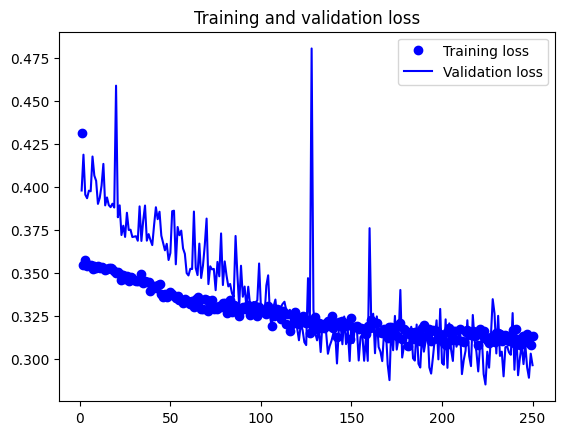

In [133]:
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

1/1 [==============================] - 0s 181ms/step


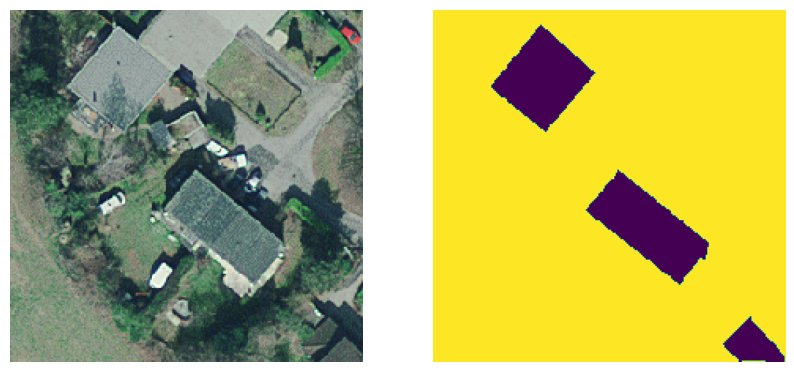

In [144]:
from tensorflow.keras.utils import array_to_img
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
model = keras.models.load_model("rooftop_segmentation.keras")
i = 2
test_image = test_input_imgs[i]
test_target = test_targets[i]
ax[0].axis("off")
ax[0].imshow(array_to_img(test_image))
ax[1].axis("off")
ax[1].imshow(array_to_img(test_target))
pred = model.predict(np.expand_dims(test_image, 0))[0]

In [135]:
def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis("off")
    plt.imshow(mask)

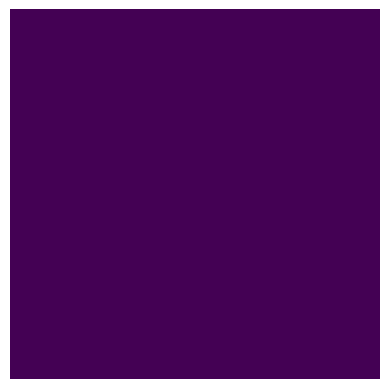

In [145]:
display_mask(pred)

In [150]:
pred.shape

(224, 224, 2)

In [146]:
pred[:,:,0].min(), pred[:,:,0].max()

(0.061350103, 0.51323956)

In [151]:
pred[:,:,1].min(), pred[:,:,1].max()

(0.4923301, 0.92784584)

In [148]:
test_target.min(), test_target.max()

(0, 1)

In [149]:
test_target.shape

(224, 224, 1)